In [280]:
%cd /content/drive/MyDrive/_Projects/epistasis/cs229_project/

/content/drive/MyDrive/_Projects/epistasis/cs229_project


In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sklearn

!pip install biopython

from Bio import SeqIO

from scipy.spatial import distance

In [282]:
from __future__ import print_function
import time

# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [285]:
node_emb_vectors = pickle.load(open('80train_sparse_node_embeddings.p', 'rb'))
node_emb_labels = list(pickle.load(open('80train_sparse_node_embedding_labels.p', 'rb')))

# node_emb_vectors = pickle.load(open('01train_sparse_node_embeddings.p', 'rb'))
# node_emb_labels = list(pickle.load(open('01train_sparse_node_embedding_labels.p', 'rb')))

In [286]:
df_emb = pd.DataFrame(np.real(node_emb_vectors))

In [287]:
def map_aa(x):
    y = np.nan
    if x in ['G','A','V','L','M','I']:
        y = 'nonpolar aliphatic'
    if x in ['S','T','C','P','N','Q']:
        y = 'polar'
    if x in ['K','R','H']:
        y = 'positive'
    if x in ['D','E']:
        y = 'negative'
    if x in ['F','Y','W']:
        y = 'aromatic'
    return y

amino_acids = [x[-1:] for x in node_emb_labels]
positions = [int(x[0:-1]) for x in node_emb_labels]
secondary_structure = [list(pd.read_csv('../../../1PGA_DSSP.csv')['DSSP'])[x-1] for x in positions]
batch_positions = [x - x%5 for x in positions]
aa_type = [map_aa(x) for x in amino_acids]


feature = secondary_structure
# feature = batch_positions
# feature = amino_acids

df_emb['label'] = pd.DataFrame(feature)
df_emb



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,label
0,-0.257193,0.243224,-0.267771,-0.011273,0.041213,-0.172597,0.148746,-0.262742,0.179359,0.340935,0.010151,0.322712,0.083402,-0.383887,0.339350,-0.226684,0.129389,-0.407885,0.258878,0.106254,-0.222759,0.125652,-0.210589,-0.246043,0.013986,0.297557,0.270356,0.033314,0.121161,-0.313584,-0.176470,-0.188858,-0.338016,-0.214969,0.257935,-0.263159,0.197875,-0.250444,-0.241831,0.161304,...,-0.346118,-0.369219,0.274357,-0.381888,0.176639,0.335284,-0.084514,-0.224213,0.287149,0.142244,-0.049183,0.331433,-0.011050,-0.325527,0.288026,0.031131,-0.257101,0.197646,0.082719,0.252293,-0.232818,-0.128565,-0.283061,-0.509160,-0.159044,0.192860,-0.265980,0.118821,0.010624,-0.096282,-0.247751,-0.290606,0.244442,0.419741,-0.112763,0.348875,-0.301356,-0.355163,-0.291584,S
1,-0.197377,0.136335,-0.283479,0.191938,-0.033341,-0.209162,0.196246,-0.170355,-0.183631,0.187258,0.021381,0.096162,0.118907,-0.104710,0.178050,-0.214877,-0.354015,0.288738,0.217734,-0.092065,-0.188935,-0.037451,-0.284654,-0.153461,0.021389,0.163189,0.246073,0.215221,-0.029071,-0.162965,-0.185423,-0.201735,-0.000977,-0.675735,-0.339857,-0.139392,0.238069,0.077114,-0.154188,0.153313,...,-0.253667,-0.303452,0.110290,-0.303491,0.435959,0.300015,-0.052959,-0.194143,0.354337,0.328539,-0.142253,0.216662,0.047987,-0.213851,0.260064,0.158399,-0.036137,0.178290,0.395621,0.307578,-0.381315,0.306823,-0.176454,-0.166032,-0.169288,-0.039560,-0.211341,0.371257,-0.314427,-0.114222,0.298194,-0.144104,0.313983,0.232151,0.272060,0.077757,-0.047814,-0.379272,-0.287743,S
2,-0.381986,0.488688,-0.353855,0.236322,0.100139,0.144977,0.185666,-0.123368,0.096186,0.403664,-0.190932,0.241241,0.255658,-0.316814,0.371202,-0.282423,0.086066,-0.110635,0.181555,0.231692,-0.267578,0.292278,-0.325812,-0.330813,0.189716,0.422454,0.240644,0.290157,-0.320275,-0.290082,-0.058702,-0.247838,-0.219303,-0.149717,0.209483,-0.307350,0.443520,0.167031,-0.275498,0.068149,...,-0.267947,-0.458302,0.146777,-0.338486,0.137238,0.128858,0.006514,0.004508,0.285127,0.033311,0.020711,0.325459,-0.159391,-0.261838,0.196223,0.062360,-0.245879,0.196321,-0.131262,0.321164,-0.061245,0.021424,-0.280986,-0.222184,-0.287000,0.109415,-0.341372,-0.132810,0.009418,0.134663,-0.122234,-0.315321,0.343680,0.306761,-0.139143,0.114319,-0.043092,-0.296028,-0.203283,S
3,-0.246040,0.341509,-0.305379,0.113354,-0.065190,-0.034149,-0.128539,-0.249517,0.092959,0.219140,-0.157493,0.200471,0.088937,-0.193002,0.302498,-0.309393,0.290873,0.076689,0.271544,0.103042,-0.222300,0.206907,-0.181757,-0.174996,0.006307,0.285534,0.254907,0.240902,-0.141965,-0.218056,-0.240832,-0.318662,-0.232560,-0.232548,0.170605,-0.288819,0.165502,-0.215398,-0.256478,0.028431,...,-0.291744,-0.169393,0.288678,-0.219500,0.285677,0.132817,0.201007,-0.130315,0.211905,0.173771,0.048261,0.207071,-0.178773,-0.216742,0.320858,-0.028438,-0.247522,0.236521,-0.102772,0.140270,-0.094922,-0.125947,-0.332942,-0.275607,-0.268230,0.154110,-0.291263,0.143915,-0.123270,0.113748,-0.212643,-0.214944,0.248517,0.441630,0.089327,0.181229,-0.350252,-0.374809,-0.200674,S
4,-0.188012,0.214085,-0.309688,0.006013,0.040026,-0.329439,-0.083702,-0.080440,-0.203057,0.297571,0.190353,0.214776,0.169639,-0.278259,0.166658,-0.109745,-0.223466,-0.252905,0.278436,-0.050826,-0.207548,-0.153633,-0.185925,0.021579,0.095256,0.156546,0.141086,0.252101,-0.179454,-0.251884,-0.246550,-0.183604,-0.146999,-0.364953,0.137977,-0.105469,0.254190,-0.105302,-0.192405,0.049985,...,-0.255873,-0.289911,0.250199,-0.162307,0.185754,0.102941,0.039582,-0.457518,0.318245,0.329186,-0.173213,0.227777,0.287809,-0.277936,0.192212,0.024469,-0.273227,0.164381,0.034701,0.155928,-0.296026,0.029750,-0.324735,-0.175259,-0.231276,0.100323,-0.282037,0.171688,0.142602,-0.299747,-0.183672,-0

In [288]:
time_start = time.time()
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=1)
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300, random_state=None)

tsne_results = tsne.fit_transform(df_emb[[x for x in range(200)]])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1045 samples in 0.002s...
[t-SNE] Computed neighbors for 1045 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1045
[t-SNE] Computed conditional probabilities for sample 1045 / 1045
[t-SNE] Mean sigma: 1.039706
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.387726
[t-SNE] KL divergence after 300 iterations: 0.604115
t-SNE done! Time elapsed: 5.094495058059692 seconds


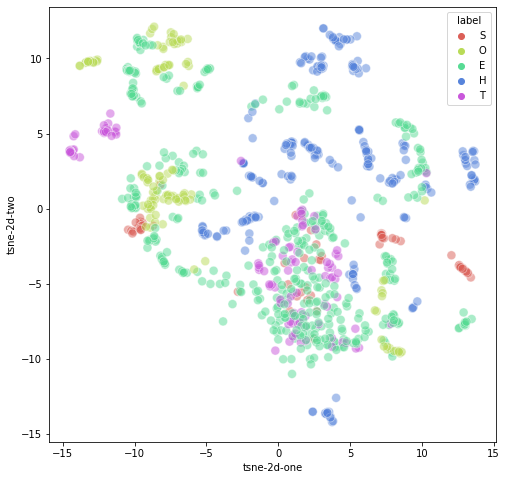

In [289]:
df_emb['tsne-2d-one'] = tsne_results[:,0]
df_emb['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", len(set(feature))),
    data=df_emb,
    legend="full",
    alpha=0.5,
    s=80,
)

In [290]:
from sklearn.cluster import KMeans


In [291]:
X = df_emb[[x for x in range(200)]]

In [292]:
kmeans = KMeans(n_clusters=len(set(feature)), init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
# tran_y = kmeans.fit_transform(X)

In [293]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=1)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal component 1', 'Principal component 2'])

principalDf['cluster'] = pd.DataFrame(pred_y, index = principalDf.index)
principalDf['label'] = pd.DataFrame(feature, index = principalDf.index)

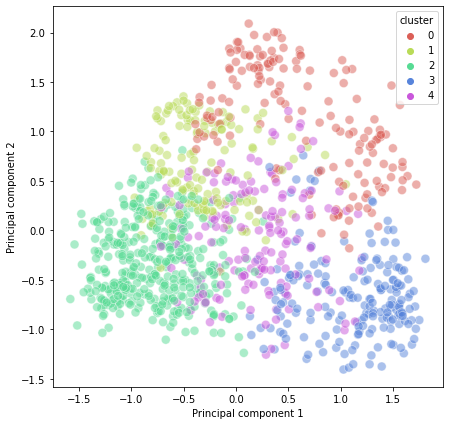

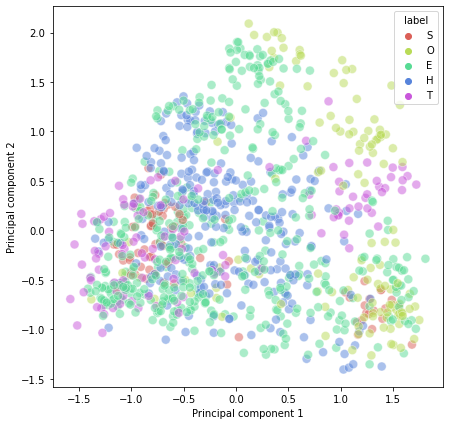

In [294]:
plt.figure(figsize=(7,7))
sns.scatterplot(
    x="Principal component 1", y="Principal component 2",
    hue="cluster",
    palette=sns.color_palette("hls", len(set(pred_y))),
    data=principalDf,
    legend="full",
    alpha=0.5,
    s=80,
)
plt.show()


plt.figure(figsize=(7,7))
sns.scatterplot(
    x="Principal component 1", y="Principal component 2",
    hue="label",
    palette=sns.color_palette("hls", len(set(feature))),
    data=principalDf,
    legend="full",
    alpha=0.5,
    s=80,
)
plt.show()

In [295]:
score = sklearn.metrics.silhouette_score(X, kmeans.labels_, metric='cosine')
print(score)

0.21246096


In [296]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=1)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal component 1', 'Principal component 2'])

principalDf['cluster'] = pd.DataFrame(pred_y, index = principalDf.index)
principalDf['label'] = pd.DataFrame(feature, index = principalDf.index)

In [297]:
X = principalDf[['Principal component 1','Principal component 2']]

In [298]:
kmeans = KMeans(n_clusters=len(set(feature)), init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
# tran_y = kmeans.fit_transform(X)

Secondary Structure
Silhouette score = 0.38785699009895325


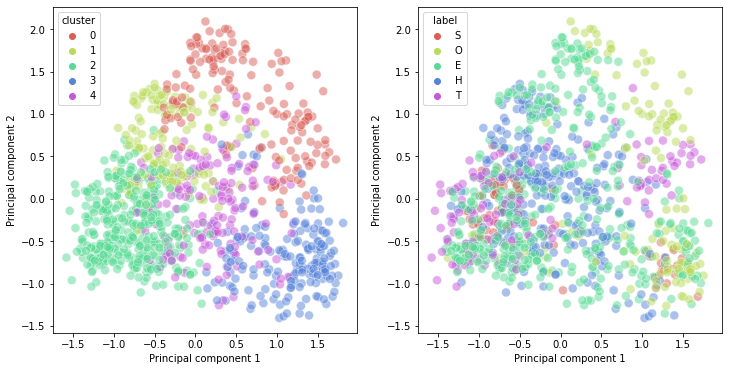

In [299]:
featurename = 'Secondary Structure'

score = sklearn.metrics.silhouette_score(X, kmeans.labels_, metric='euclidean')
print(featurename)
print(f'Silhouette score = {score}')


fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)

sns.scatterplot(
    x="Principal component 1", y="Principal component 2",
    hue="cluster",
    palette=sns.color_palette("hls", len(set(pred_y))),
    data=principalDf,
    legend="full",
    alpha=0.5,
    s=80,
    ax = ax1
)

sns.scatterplot(
    x="Principal component 1", y="Principal component 2",
    hue="label",
    palette=sns.color_palette("hls", len(set(feature))),
    data=principalDf,
    legend="full",
    alpha=0.5,
    s=80,
    ax = ax2
)
plt.show()


In [300]:
# !pip install umap-learn

# import umap.umap_ as umapy

# from scipy.spatial import distance

In [301]:
# results = df_emb[[x for x in range(200)]]
# XA = distance.squareform(distance.pdist(results))

# dmap = np.full((56,56), np.nan)
# for i in range(56):
#     for j in range(56):
#         # x = positions[i]
#         # y = positions[j]
#         XA = df_emb[[x for x in range(200)]].loc[df_emb['label']==i]
#         XB = df_emb[[x for x in range(200)]].loc[df_emb['label']==j]

#         # print(x,y)
#         dmap[i,j] = np.mean(distance.cdist(XA, XB))


# plt.figure(figsize=(9,8))
# sns.heatmap(dmap)

In [302]:
# results = df_emb[['tsne-2d-one','tsne-2d-two']]
# # results = df_emb[[x for x in range(200)]]


# XA = distance.squareform(distance.pdist(results))

# sklearn.metrics.silhouette_score(XA, labels=df_emb['label'], metric='precomputed')

In [303]:
# umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
# # umap_3d = UMAP(n_components=3, init='random', random_state=0)

# umap_results = umap_2d.fit_transform(df_emb[[x for x in range(200)]])

In [304]:
# df_emb['umap-2d-one'] = umap_results[:,0]
# df_emb['umap-2d-two'] = umap_results[:,1]
# plt.figure(figsize=(8,8))
# sns.scatterplot(
#     x="umap-2d-one", y="umap-2d-two",
#     hue="label",
#     palette=sns.color_palette("hls", len(set(feature))),
#     data=df_emb,
#     legend="full",
#     alpha=0.5,
#     s=80,
# )

In [305]:
# results = df_emb[['umap-2d-one','umap-2d-two']]


# XA = distance.squareform(distance.pdist(results))

# sklearn.metrics.silhouette_score(XA, labels=df_emb['label'], metric='precomputed')

In [306]:

# condition = 'S'

# results = df_emb[['umap-2d-one','umap-2d-two']].loc[df_emb['label']==condition]


# XA = distance.squareform(distance.pdist(results))

# sklearn.metrics.silhouette_score(XA, labels=df_emb['label'].loc[df_emb['label']==condition], metric='precomputed')

In [307]:
# from scipy.cluster.hierarchy import dendrogram, linkage
 
# plt.figure(facecolor='white',figsize=(50,5))

# # Calculate the distance between each sample
# Z = linkage(df_emb[[x for x in range(200)]], 'ward')

# dendrogram(Z, labels=feature, leaf_font_size = 15, )

# my_palette = plt.cm.get_cmap("Accent", 15)

# ax = plt.gca()
# xlbls = ax.get_xmajorticklabels()

# my_color = [x for x in range(len(set(feature)))]
# # xlbls = list(df.label)
# # num=-1
# for i,lbl in enumerate(xlbls):
#   j = list(set(feature)).index(feature[i])
#   val=my_color[j]
#   lbl.set_color(my_palette(val))


# # # [x.get_text() for x in xlbls]
# # # list(df.label)
# # # type(xlbls)